In [2]:
import os
import json
import itertools
import glob
import re
import pandas as pd
import numpy as np

from itertools import product

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize,LinearSegmentedColormap
from matplotlib.cm import get_cmap, ScalarMappable
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colorbar as cbar
from matplotlib.legend_handler import HandlerBase
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import AnchoredText


import seaborn as sns
import colorsys
import cmocean

from adjustText import adjust_text

import networkx as nx
import pydot

import splines
from scipy.interpolate import make_interp_spline
import bezier

In [3]:
os.environ["QT_API"] = "PyQt6"

In [4]:
#rcParams["font.family"] = "Times New Roman"
pd.set_option('display.max_rows', 500)
matplotlib.use('QtAgg')

In [5]:
%matplotlib inline

In [6]:
df = pd.read_csv('finalMetric.csv',index_col = 0) 

In [7]:
# Check if the column is numeric
def is_numeric(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Transform the data for plotting
def adapt_data_to_plot(y, parameter_space, my_vars_names):
    ym = []
    for v, var in enumerate(my_vars_names):
        if var in parameter_space:
            ticks = parameter_space[var]
            num_ticks = len(ticks)
            # Convert the values in y to the correct types
            y_vals = y[:, v]
            if is_numeric(y_vals[0]):
                y_vals = y[:, v].astype(float).astype(str)
            else:
                y_vals = y[:, v].astype(str)
            ym += [np.array([ticks.index(val) / (num_ticks - 1) for val in y_vals])]
        else:
            ym += [y[:, v]]
    return np.array(ym).T


# Format the target ax
def format_axes(host_ax,top=True):
    # Make the axes:
    axes = [host_ax] + [host_ax.twinx() for i in range(ym.shape[1] - 1)]
    for i, ax in enumerate(axes):
        ax.set_ylim(bottom=ymins[i], top=ymaxs[i])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax != host_ax:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('right')
            ax.spines['right'].set_position(('axes', i / (ym.shape[1] - 1)))

        # Set ticks for each axis
        if my_vars_names[i] in my_vars_names[:-1]:
            ax.set_yticks(np.linspace(0, 1, len(parameter_space[my_vars_names[i]])))
            if (is_numeric(parameter_space[my_vars_names[i]][0]) & (i not in [2,3,5])):
                ax.set_yticklabels([int(float(x)) for x in parameter_space[my_vars_names[i]]])
            else:
                ax.set_yticklabels(parameter_space[my_vars_names[i]])
        else:
            ax.set_yticks(np.linspace(0, 1, 2))
            ax.set_yticklabels(["0.020","0.235"],ha="left")
            ax.tick_params(axis='y', which='major', pad=1.5)
            ax.tick_params(length=0)
            ax.yaxis.get_ticklabels()[0].set_va("top")  
            ax.yaxis.get_ticklabels()[1].set_va("bottom")     

        for label in ax.get_yticklabels():
            label.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
            
    host_ax.set_xlim(0, ym.shape[1] - 1)

    if top == True:
        host_ax.set_xticks(range(ym.shape[1]))
        host_ax.set_xticklabels([name2print[var] for var in my_vars_names], fontsize=14)
        host_ax.xaxis.tick_top()
    else:
        host_ax.set_xticklabels([])
        
    host_ax.tick_params(axis='x', which='major', pad=7)
    host_ax.spines['right'].set_visible(False)
    

    
def compute_control_points(row,s=0.5):
    centroids = np.column_stack([np.arange(len(row)), row])
    cols = len(centroids)
    a = s  # smoothness
    cps = []

    cps.append(centroids[0])
    cps.append(np.array([centroids[0][0] + a * 2 * (centroids[1][0] - centroids[0][0]), centroids[0][1]]))
    
    for col in range(1, cols - 1):
        mid = centroids[col]
        left = centroids[col - 1]
        right = centroids[col + 1]

        diff = left - right
        cps.append(mid + a * diff)
        cps.append(mid)
        cps.append(mid - a * diff)
    
    cps.append(np.array([centroids[cols - 1][0] + a * 2 * (centroids[cols - 2][0] - centroids[cols - 1][0]), centroids[cols - 1][1]]))
    cps.append(centroids[cols - 1])

    return np.array(cps)



def plot_top_n_curves_b(a, b, ax, ascending=True):

    # Sort the dataframe based on the final metric
    df_sorted = df_plot.sort_values(by='finalMetricData', ascending=ascending).iloc[a:b].copy()

    x = np.arange(ym.shape[1])
    for j in df_sorted.index:
        # Compute centroids
        centroids = ym[j]
        
        # Compute control points
        control_points = compute_control_points(centroids,s=0.1)
        #print(control_points)

        # Generate Bezier curve points
        curve_points = []
        for i in range(0, len(control_points) - 3, 3):
            nodes = np.asfortranarray([
                control_points[i:i + 4, 0],
                control_points[i:i + 4, 1],
            ])
            curve = bezier.Curve(nodes, degree=3)
            s_vals = np.linspace(0.0, 1.0,10240)
            points = curve.evaluate_multi(s_vals)
            curve_points.extend(points.T)

        curve_points = np.array(curve_points)

        # Draw the curve
        verts = curve_points
        codes = [Path.MOVETO] + [Path.LINETO] * (len(verts) - 1)
        path = Path(verts, codes)
        color_final_metric = cmap(norm(df_plot.loc[j]['finalMetricData']))
        patch = patches.PathPatch(path, facecolor='none', lw=0.6, alpha=0.8, edgecolor=color_final_metric,antialiased=True)
        ax.add_patch(patch)

        
def interpolate_hsl(color1, color2, t):
    # Convert hex to RGB
    c1_rgb = mcolors.hex2color(color1)
    c2_rgb = mcolors.hex2color(color2)

    # Convert RGB to HSL
    c1_hls = colorsys.rgb_to_hls(*c1_rgb)
    c2_hls = colorsys.rgb_to_hls(*c2_rgb)

    # Interpolate HSL values
    h = c1_hls[0] + t * (c2_hls[0] - c1_hls[0])
    l = c1_hls[1] + t * (c2_hls[1] - c1_hls[1])
    s = c1_hls[2] + t * (c2_hls[2] - c1_hls[2])

    # Convert HSL back to RGB and return as a hex string
    return mcolors.rgb2hex(colorsys.hls_to_rgb(h, l, s))

def custom_cmap(colors, value):
    if value <= 0.5:
        t = value / 0.5
        return interpolate_hsl(colors[0], colors[1], t)
    else:
        t = (value - 0.5) / 0.5
        return interpolate_hsl(colors[1], colors[2], t)

def add_subplot_label(ax, label, loc='lower left'):
    anchored_text = AnchoredText(label, loc=loc, prop=dict(size=14),borderpad = -0,bbox_to_anchor=(-0.1,1.12),bbox_transform = ax.transAxes, pad=0.2, frameon=False)
    #anchored_text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(anchored_text)
    

def add_colorbar(ax, norm, cmap, ylabel):
    cbar_ax = ax.inset_axes([1, 0.116, 0.05, 0.771])  # Adjust the position and size of the colorbar
    cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax=cbar_ax)
    #cbar.ax.set_ylabel(ylabel, rotation=90)
    cbar.set_ticks([])
    cbar.outline.set_visible(False)

In [96]:
# DataFrame and column names
df_plot = df.copy().drop(columns = 'id')
my_vars_names = ['hidden_layer_number', 'layer_size', 'learning_rate', 'act_func', 'modify_weights', 'lambda_1', 'finalMetricData']
name2print = {'hidden_layer_number':'Hidden\n Layers', 'layer_size':'Nodes', 'learning_rate':'Learning\n Rate', 'act_func':'Activation\n Functions', 'modify_weights':'Weight\n Modified', 'lambda_1':'λ', 'finalMetricData':'RMSE'}
# Reorder the DataFrame columns based on the new order
df_plot = df_plot[my_vars_names]

parameter_space = {
    "modify_weights": ["0.0", "1.0"],
    "lambda_1": ["0.0", "0.3", "1.0", "2.0"],
    "act_func": ["Tanh", "Sigmoid", "ReLU", "LeakyReLU", "Softplus"],
    "hidden_layer_number": ["1.0", "2.0", "3.0"],
    "layer_size": ["16.0", "32.0", "64.0"],
    "learning_rate": ["0.001", "0.005", "0.01", "0.05"]
}


# Adapt the data
y = df_plot.to_numpy()
ym = adapt_data_to_plot(y, parameter_space, my_vars_names)
final_metric_min = df_plot['finalMetricData'].min()
final_metric_max = df_plot['finalMetricData'].max()

ym[:, -1] = (ym[:, -1].astype(float) - final_metric_min) / (final_metric_max - final_metric_min)

# Get ymins and ymaxs
ymins = ym.min(axis=0)
ymaxs = ym.max(axis=0)
dys = ymaxs - ymins

# Padding
ymins -= dys * 0.15
ymaxs += dys * 0.15

# Reverse some axes for better visual
axes_to_reverse = []  # No need to reverse any axes now
for a in axes_to_reverse:
    ymaxs[a], ymins[a] = ymins[a], ymaxs[a]
dys = ymaxs - ymins


norm = Normalize(vmin=df_plot['finalMetricData'].min(), vmax=df_plot['finalMetricData'].max())



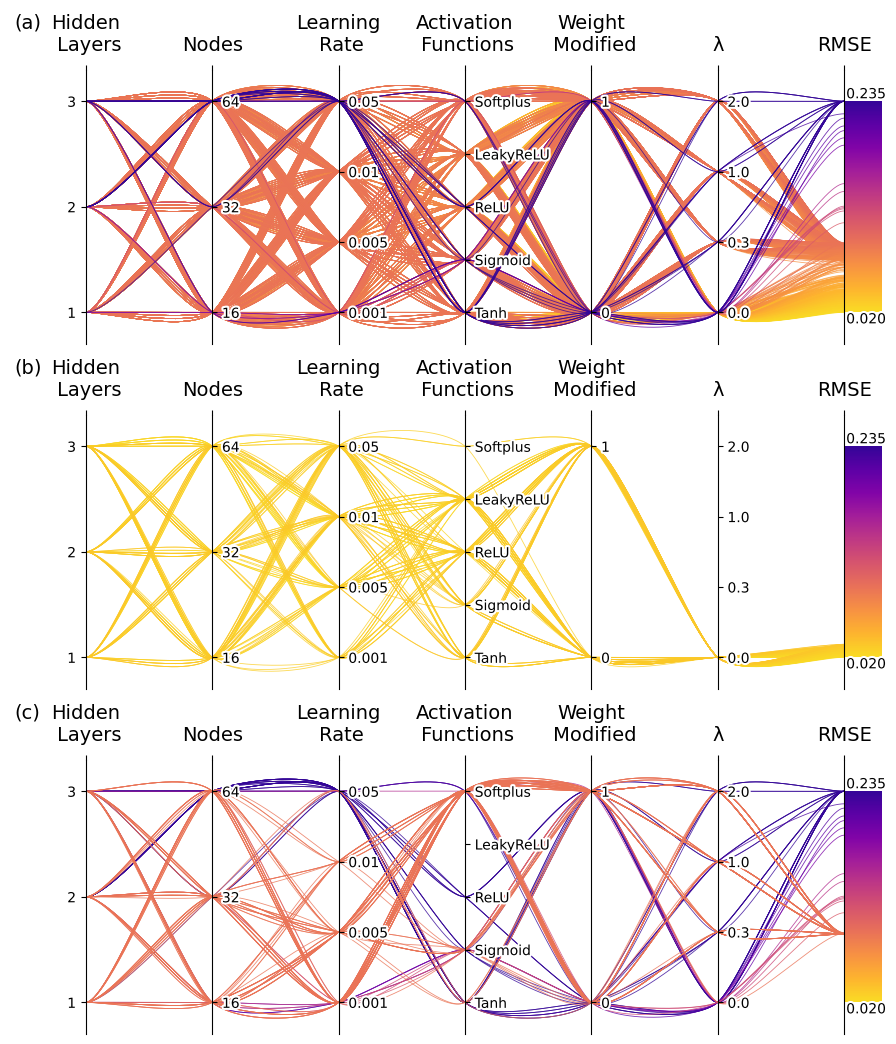

In [191]:
# cool 1
# Plot:
cm_plasma = sns.color_palette("plasma", as_cmap=True)
colors = cm_plasma(np.linspace(0.07, 0.93, 10)[::-1])
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig = plt.figure(figsize=(9,10.5),tight_layout=True)

gs = fig.add_gridspec(3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])


format_axes(ax1)
format_axes(ax2)
format_axes(ax3)

plot_top_n_curves_b(0,1440, ax1)
plot_top_n_curves_b(0,144, ax2)
plot_top_n_curves_b(0,144, ax3, ascending=False)


add_colorbar(ax1, norm, cmap, 'RMSE')
add_colorbar(ax2, norm, cmap, 'RMSE')
add_colorbar(ax3, norm, cmap, 'RMSE')


add_subplot_label(ax1, '(a)')
add_subplot_label(ax2, '(b)')
add_subplot_label(ax3, '(c)')

plt.show()
fig.savefig('panel1_M30.png',dpi=300,bbox_inches='tight')

In [192]:
fig.savefig('panel1_2.png',dpi=300)

In [196]:
dfraw = pd.read_parquet('df_nn_extended_april.parquet')

In [393]:
def load_cate_data(act_func, weight_mod, lbd,layer,node,lr):
    if weight_mod == 0:
        wm = "w0"
        pref = "ovgkf97l"
    elif weight_mod == 1:
        wm = "w1"
        pref = "tqu0j7bk"
    else:
        return 'false'
    return pd.read_csv(r".\{0}\{1}_causal_effect_layer_{2}node_{3}_{4}_LR_{5}weightmod_{6}lbd_{7}.csv".format(wm,pref,layer,node,act_func,lr,weight_mod,lbd),index_col=0)

# Function to add activation function names
def add_activation_name(ax, name):
    ax.set_title(name, fontsize=11)

# Function to add lambda values
def add_lambda_value(ax, value,padding = 0.3):
    ax.annotate(
        f"$\lambda = {value}$",
        xy=(-padding, 0.5),
        xycoords="axes fraction",
        fontsize=14,
        fontweight="bold",
        rotation=90,
        ha="right",
        va="center",
    )


In [248]:

boundaries = np.array([-3, -1,-0.7,-0.5,-0.3, -0.1, -0.01, -0.001,0, 0.001, 0.01,0.1,0.3,0.5,0.7, 1, 3])
colors = [sns.color_palette("Spectral", as_cmap=True)(x) for x in np.linspace(0, 1, len(boundaries))]
#colors = [cmocean.cm.haline(x) for x in np.linspace(0, 1, len(boundaries))]
#colors = [sns.color_palette("viridis", as_cmap=True)(x) for x in np.linspace(0, 1, len(boundaries))]
segmented_cmap = ListedColormap(colors)

norm = BoundaryNorm(boundaries, len(colors))

C:\Miniconda3\envs\causal\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


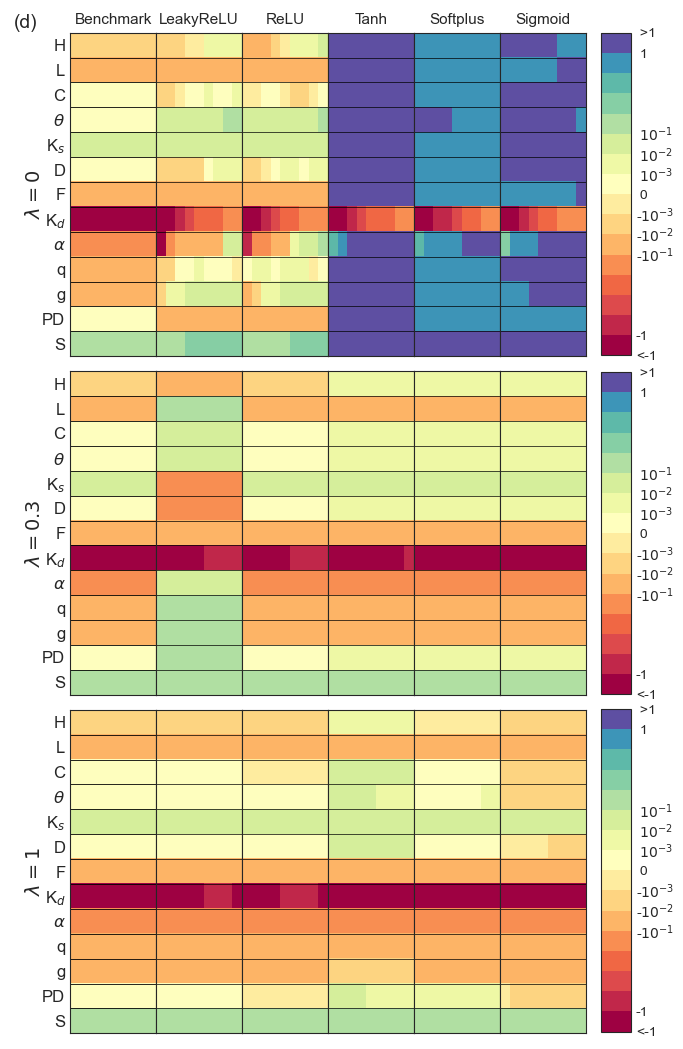

In [443]:

ruler = np.array([-0.001219236, -0.035074218, 0, 0, 0.033900008, 0.000465403, -0.042283258, -1.064407829, -0.144739628, -0.025415903, -0.019302039, 0, 0.162546474]).reshape(-1, 1)

# Plot:
fig = plt.figure(figsize=(6, 10.5),tight_layout=True)


gs = fig.add_gridspec(3,6,width_ratios=[10,10,10,10,10,10],wspace=0)

params = [(0,0),(0,0.3),(0,1)]
# Define your parameters
other_params = [
    [1, 2, 3],
    [16,32,64],
    [0.001,0.005,0.01,0.05]  # your additional parameters
]
param_combinations = list(product(*other_params))
axes = []
act_func_dict = {1:'LeakyReLU',2:'ReLU',3:'Tanh',4:'Softplus',5:'Sigmoid'}

for i in range(3):
    for j in range(6):
        ax = fig.add_subplot(gs[i,j])

        if j == 0:
            ax.imshow(ruler, aspect="auto", cmap=segmented_cmap,norm=norm)
            
            # Major ticks
            ax.set_yticks(range(13))

            # Labels for major ticks
            ax.set_xticklabels([])
            ax.set_yticklabels(['H','L','C',r'$\theta$','K$_s$','D','F','K$_d$',r'$\alpha$','q','g','PD','S'],fontsize=12)

            # Minor ticks
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.6)

            # Remove minor ticks
            ax.tick_params(which='minor', bottom=False, left=False)
            ax.tick_params(axis='both', which='both', length=0)
            
            add_lambda_value(ax, params[i][1])
            
            if i not in (1,2):
                anchored_text = AnchoredText("(d)", loc="upper left", prop=dict(size=14),borderpad = -0,bbox_to_anchor=(-0.7,1.07),bbox_transform = ax.transAxes, pad=0.2, frameon=False)
                #anchored_text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
                ax.add_artist(anchored_text)
        else:
            # Create a list to store your dataframes
            dataframes = []

            # Load data for each parameter combination
            for para in param_combinations:
                dataframes.append(load_cate_data(act_func_dict[j],*params[i],*para))
            data = pd.concat(dataframes).groupby(level=0).mean()
            # Concatenate and average data
            
            #data = load_cate_data(act_func_dict[j],*params[i],*(1,32,0.01))
            ax.imshow(data.T.iloc[:,1:], aspect="auto", cmap=segmented_cmap,norm=norm)
            ax.set_yticks(np.arange(0, 13, 1))
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.5)
            ax.tick_params(which='minor', bottom=False, left=False)
            #ax.grid( color='w', linestyle='-', linewidth=2)
            ax.set_xticks([])
            ax.set_yticks([])
        
        if i == 0 and j > 0:
            add_activation_name(ax, act_func_dict[j])
        elif i== 0 and j == 0:
            add_activation_name(ax, "Benchmark")

cbar_ax1 = fig.add_axes([1, 0.66, 0.05, 0.307])
cbar_ax2 = fig.add_axes([1, 0.337, 0.05, 0.307])
cbar_ax3 = fig.add_axes([1, 0.016, 0.05, 0.307])

cbar1 = fig.colorbar(ScalarMappable(norm=norm, cmap=segmented_cmap), cax=cbar_ax1,ticks=boundaries)
cbar2 = fig.colorbar(ScalarMappable(norm=norm, cmap=segmented_cmap), cax=cbar_ax2,ticks=boundaries)
cbar3 = fig.colorbar(ScalarMappable(norm=norm, cmap=segmented_cmap), cax=cbar_ax3,ticks=boundaries)

for ax in [cbar_ax1,cbar_ax2,cbar_ax3]:
    ax.set_yticklabels(['<-1', '-1','','','','-$10^{-1}$','-$10^{-2}$', '-$10^{-3}$', ' 0',' $10^{-3}$',' $10^{-2}$',' $10^{-1}$','','','', ' 1',' >1'])
    ax.tick_params(axis='both', which='both', length=0)
    


    
plt.show()
fig.savefig('panel2_M30.png',dpi=300,bbox_inches='tight')

C:\Miniconda3\envs\causal\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


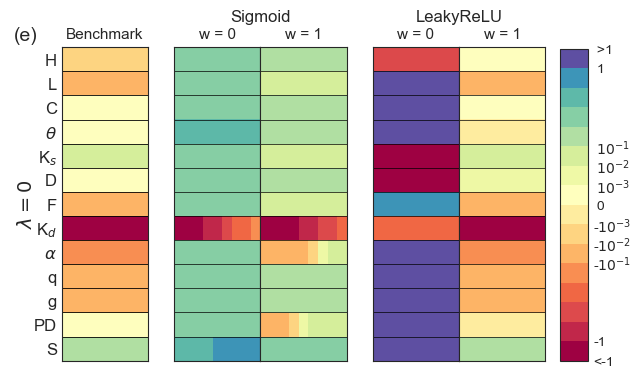

In [444]:
fig = plt.figure(figsize=(5.6, 3.8),tight_layout=True)

gs = fig.add_gridspec(1,7,width_ratios=[10,3,10,10,3,10,10],wspace=0)

params_1 = [(0,0),(1,0)]
params_2 = [(0,0.3),(1,0.3)]
act_func_dict = {1:'LeakyReLU',2:'ReLU',3:'Tanh',4:'Softplus',5:'Sigmoid'}

for i in range(1):
    for j in range(7):
        ax = fig.add_subplot(gs[i,j])

        if j == 0:
            ax.imshow(ruler, aspect="auto", cmap=segmented_cmap,norm=norm)
            
            # Major ticks
            ax.set_yticks(range(13))

            # Labels for major ticks
            ax.set_xticklabels([])
            ax.set_yticklabels(['H','L','C',r'$\theta$','K$_s$','D','F','K$_d$',r'$\alpha$','q','g','PD','S'],fontsize=12)

            # Minor ticks
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.6)

            # Remove minor ticks
            ax.tick_params(which='minor', bottom=False, left=False)
            ax.tick_params(axis='both', which='both', length=0)
            add_activation_name(ax, "Benchmark")
            add_lambda_value(ax, params[i][1])

            anchored_text = AnchoredText("(e)", loc="upper left", prop=dict(size=14),borderpad = -0,bbox_to_anchor=(-0.6,1.08),bbox_transform = ax.transAxes, pad=0.2, frameon=False)
            #anchored_text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax.add_artist(anchored_text)
            
        elif j in [2,3]:
            data = load_cate_data(act_func_dict[5],*params_1[j%2],*(2,64,0.001))
            ax.imshow(data.T.iloc[:,1:], aspect="auto", cmap=segmented_cmap,norm=norm)
            ax.set_yticks(np.arange(0, 13, 1))
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.5)
            ax.tick_params(which='minor', bottom=False, left=False)
            #ax.grid( color='w', linestyle='-', linewidth=2)
            ax.set_xticks([])
            ax.set_yticks([])
            add_activation_name(ax, "w = {}".format(j%2))
            if j == 2:
                ax.annotate(act_func_dict[5], xy=(1, 1.06), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size=12, ha='center', va='baseline')

        elif j in [5,6]:
            data = load_cate_data(act_func_dict[1],*params_2[(j-1)%2],*(3,64,0.05))
            ax.imshow(data.T.iloc[:,1:], aspect="auto", cmap=segmented_cmap,norm=norm)
            ax.set_yticks(np.arange(0, 13, 1))
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.5)
            ax.tick_params(which='minor', bottom=False, left=False)
            #ax.grid( color='w', linestyle='-', linewidth=2)
            ax.set_xticks([])
            ax.set_yticks([])
            add_activation_name(ax, "w = {}".format((j-1)%2))
            if j == 5:
                ax.annotate(act_func_dict[1], xy=(1, 1.06), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size=12, ha='center', va='baseline')

        else:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')

            

cbar_ax3 = fig.add_axes([1, 0.04, 0.05, 0.82])
cbar3 = fig.colorbar(ScalarMappable(norm=norm, cmap=segmented_cmap), cax=cbar_ax3,ticks=boundaries)

cbar_ax3.set_yticklabels(['<-1', '-1','','','','-$10^{-1}$','-$10^{-2}$', '-$10^{-3}$', ' 0',' $10^{-3}$',' $10^{-2}$',' $10^{-1}$','','','', ' 1',' >1'])
cbar_ax3.tick_params(axis='both', which='both', length=0)
# Create a colorbar
#cax = fig.add_axes([0.92, 0.125, 0.03, 0.755])
#cbar = fig.colorbar(im2, cax=cax, ticks=boundaries)
#cbar.ax.set_yticklabels(['<-1', '-1','','','','-0.1','-0.01', '-0.001', '0.001','0.01','0.1','','','', '1','>1'])
#yticks = cbar.ax.yaxis.get_major_ticks()
#for i in range(2,5):
#    yticks[i].set_visible(False)
#for i in range(10,14):
#    yticks[i].set_visible(False)"""

plt.show()
fig.savefig('panel3_M30.png',dpi=300,bbox_inches='tight')

C:\Miniconda3\envs\causal\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


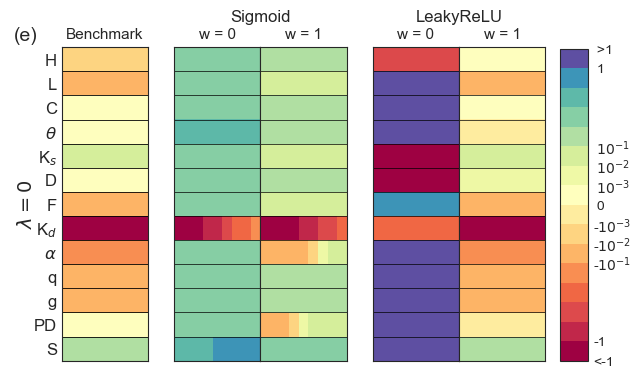

In [444]:
fig = plt.figure(figsize=(5.6, 3.8),tight_layout=True)

gs = fig.add_gridspec(1,7,width_ratios=[10,3,10,10,3,10,10],wspace=0)

params_1 = [(0,0),(1,0)]
params_2 = [(0,0.3),(1,0.3)]
act_func_dict = {1:'LeakyReLU',2:'ReLU',3:'Tanh',4:'Softplus',5:'Sigmoid'}

for i in range(1):
    for j in range(7):
        ax = fig.add_subplot(gs[i,j])

        if j == 0:
            ax.imshow(ruler, aspect="auto", cmap=segmented_cmap,norm=norm)
            
            # Major ticks
            ax.set_yticks(range(13))

            # Labels for major ticks
            ax.set_xticklabels([])
            ax.set_yticklabels(['H','L','C',r'$\theta$','K$_s$','D','F','K$_d$',r'$\alpha$','q','g','PD','S'],fontsize=12)

            # Minor ticks
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.6)

            # Remove minor ticks
            ax.tick_params(which='minor', bottom=False, left=False)
            ax.tick_params(axis='both', which='both', length=0)
            add_activation_name(ax, "Benchmark")
            add_lambda_value(ax, params[i][1])

            anchored_text = AnchoredText("(e)", loc="upper left", prop=dict(size=14),borderpad = -0,bbox_to_anchor=(-0.6,1.08),bbox_transform = ax.transAxes, pad=0.2, frameon=False)
            #anchored_text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax.add_artist(anchored_text)
            
        elif j in [2,3]:
            data = load_cate_data(act_func_dict[5],*params_1[j%2],*(2,64,0.001))
            ax.imshow(data.T.iloc[:,1:], aspect="auto", cmap=segmented_cmap,norm=norm)
            ax.set_yticks(np.arange(0, 13, 1))
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.5)
            ax.tick_params(which='minor', bottom=False, left=False)
            #ax.grid( color='w', linestyle='-', linewidth=2)
            ax.set_xticks([])
            ax.set_yticks([])
            add_activation_name(ax, "w = {}".format(j%2))
            if j == 2:
                ax.annotate(act_func_dict[5], xy=(1, 1.06), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size=12, ha='center', va='baseline')

        elif j in [5,6]:
            data = load_cate_data(act_func_dict[1],*params_2[(j-1)%2],*(3,64,0.05))
            ax.imshow(data.T.iloc[:,1:], aspect="auto", cmap=segmented_cmap,norm=norm)
            ax.set_yticks(np.arange(0, 13, 1))
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.5)
            ax.tick_params(which='minor', bottom=False, left=False)
            #ax.grid( color='w', linestyle='-', linewidth=2)
            ax.set_xticks([])
            ax.set_yticks([])
            add_activation_name(ax, "w = {}".format((j-1)%2))
            if j == 5:
                ax.annotate(act_func_dict[1], xy=(1, 1.06), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size=12, ha='center', va='baseline')

        else:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')

            

cbar_ax3 = fig.add_axes([1, 0.04, 0.05, 0.82])
cbar3 = fig.colorbar(ScalarMappable(norm=norm, cmap=segmented_cmap), cax=cbar_ax3,ticks=boundaries)

cbar_ax3.set_yticklabels(['<-1', '-1','','','','-$10^{-1}$','-$10^{-2}$', '-$10^{-3}$', ' 0',' $10^{-3}$',' $10^{-2}$',' $10^{-1}$','','','', ' 1',' >1'])
cbar_ax3.tick_params(axis='both', which='both', length=0)
# Create a colorbar
#cax = fig.add_axes([0.92, 0.125, 0.03, 0.755])
#cbar = fig.colorbar(im2, cax=cax, ticks=boundaries)
#cbar.ax.set_yticklabels(['<-1', '-1','','','','-0.1','-0.01', '-0.001', '0.001','0.01','0.1','','','', '1','>1'])
#yticks = cbar.ax.yaxis.get_major_ticks()
#for i in range(2,5):
#    yticks[i].set_visible(False)
#for i in range(10,14):
#    yticks[i].set_visible(False)"""

plt.show()
fig.savefig('panel3_M30.png',dpi=300,bbox_inches='tight')

In [ ]:
# Can 'revive' a network from lambda-induced regularization failure and inject interpretability
df[(df['act_func']=='Softplus')&(df['hidden_layer_number']==3)&(df['layer_size']==64)&(df['learning_rate']==0.05)].sort_values(by='finalMetricData', ascending=True)

In [334]:
# Function to filter files using a regex pattern
def filter_files(files, pattern):
    return [file for file in files if re.search(pattern, file)]

# Function to read test losses from a list of CSV files
def read_test_losses(files):
    test_losses = []
    for file in files:
        df = pd.read_csv(file)
        test_losses.append(df['Test Loss'].values)
    return test_losses

def zoom_axes(fig,ax,zoom_x,zoom_y,axes_x,axes_y,box=True,box_color='#420C09',box_alpha=0.8,connect=True,connect_color='k',connect_alpha=1,spacing=4,tick_width=20,tick_height=12):

    plt.tight_layout()
    ax1_p0 = (ax.transData + fig.transFigure.inverted()).transform_point((axes_x[0],axes_y[0]))
    ax1_p1 = (ax.transData + fig.transFigure.inverted()).transform_point((axes_x[1],axes_y[1]))

    ax1 = plt.axes([ax1_p0[0],ax1_p0[1],ax1_p1[0]-ax1_p0[0],ax1_p1[1]-ax1_p0[1]])

    ax1.set_xlim(zoom_x)
    ax1.set_ylim(zoom_y)

    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)
    ax1.tick_params(axis='x', pad=3)
    ax1.tick_params(axis='y', pad=2)

    if box:
        ax.plot([zoom_x[0],zoom_x[1],zoom_x[1],zoom_x[0],zoom_x[0]],[zoom_y[0],zoom_y[0],zoom_y[1],zoom_y[1],zoom_y[0]],color=box_color,alpha=box_alpha,linewidth=0.6)

    return ax1

# Custom legend handler
class ShadedLegendHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        p = plt.Rectangle([xdescent, ydescent], width, height, facecolor=orig_handle.get_facecolor())
        return [p]

In [335]:
# Define the regex pattern
pattern01 = r'\.\\w0\\.*_loss_layer_.*node_.*_.*_LR_.*weightmod_0lbd_(0\.3|1|2)\.csv'
pattern00 = r'\.\\w0\\.*_loss_layer_.*node_.*_.*_LR_.*weightmod_0lbd_0\.csv'
pattern11 = r'\.\\w1\\.*_loss_layer_.*node_.*_.*_LR_.*weightmod_1lbd_(0\.3|1|2)\.csv'
pattern10 = r'\.\\w1\\.*_loss_layer_.*node_.*_.*_LR_.*weightmod_1lbd_0\.csv'
# Get all the CSV files in the directory
w0_files = glob.glob('.\w0\*.csv')
w1_files = glob.glob('.\w1\*.csv')
# Filter the files based on the regex pattern
g01 = filter_files(w0_files, pattern01)
g00 = filter_files(w0_files, pattern00)
g10 = filter_files(w1_files, pattern10)
g11 = filter_files(w1_files, pattern11)

"for i, (rect, group_name) in enumerate(zip(rectangles, groups.keys())):\n    handles.append(rect)\n    labels.append(f'{group_name} CI')"

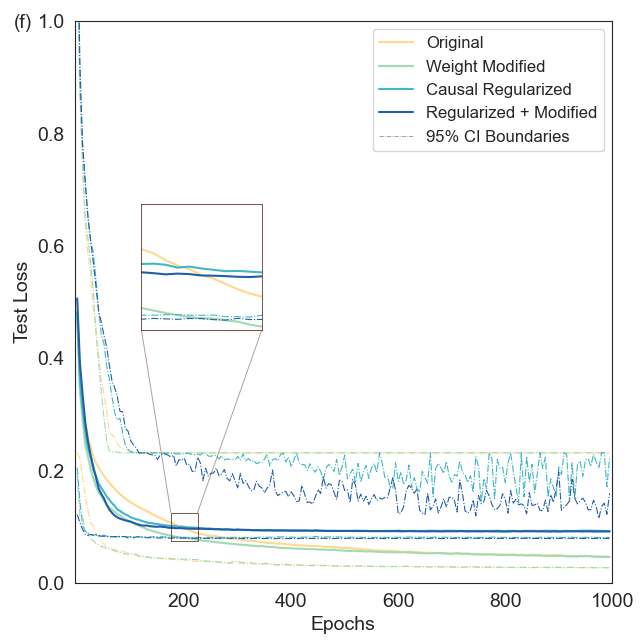

In [392]:
sns.set_style("white")
colors =['#fed98e','#a1dab4','#41b6c4','#225ea8']#[::-1]
"""colors = ["#0000ff",
"#9d02d7",
"#ffb14e",
"#ffd700"]"""
#colors = ['#7fc97f','#beaed4','#fdc086','#ffff99']
# Group the CSV files based on a and b values
groups = {
    'Original': g00,
    'Weight Modified': g10,
    'Causal Regularized': g01,
    'Regularized + Modified': g11,
}

group_test_losses = {}
for group_name, group_files in groups.items():
    test_losses = read_test_losses(group_files)
    test_losses_array = np.array(test_losses)
    # Not a single experiment!
    lower_2_5 = np.percentile(test_losses_array, 2.5, axis=0)
    upper_97_5 = np.percentile(test_losses_array, 97.5, axis=0)

    # Create a mask to filter out values below the 2.5 percentile and above the 97.5 percentile
    mask = np.logical_and(test_losses_array >= lower_2_5, test_losses_array <= upper_97_5)

    # Apply the mask and calculate the mean
    filtered_test_losses = [test_losses_array[i] for i in range(len(test_losses_array)) if mask[i].all()]
    filtered_mean = np.mean(filtered_test_losses, axis=0)

    group_test_losses[group_name] = {'mean': filtered_mean,'ci_lower': lower_2_5, 'ci_upper': upper_97_5}

x_range = np.arange(0, 995+1, 5)

# Create a single plot
fig, ax = plt.subplots(figsize=(6.5, 6.5))

# Plot the data for each group
for i, (group_name, test_losses) in enumerate(group_test_losses.items()):
    sns.lineplot(x=x_range, y=test_losses['mean'], ax=ax, label=group_name, color=colors[i],linewidth = 1.5)
    #ax.fill_between(x_range, test_losses['ci_lower'], test_losses['ci_upper'], color=colors[i], alpha=0.6)
    # Plot CI using dashed lines
    ax.plot(x_range, test_losses['ci_lower'], linestyle="-.", linewidth=0.8,color=colors[i])
    ax.plot(x_range, test_losses['ci_upper'], linestyle="-.",  linewidth=0.8,color=colors[i])
    



ax.set_xlim(-5, x_range.max())
ax.set_ylim(0, 1)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Test Loss', fontsize=14)

ticks = ax.get_xticks()
ticks = ticks[1:] 
ax.set_xticks(ticks)
ax.set_xticklabels([" ",200,400,600,800,1000], fontsize=14)
plt.yticks(fontsize=14)


# Define the zoomed-in region and the location of the new axes
zoom_x = [175,225]  # Adjust the x-axis range for the zoomed-in region
zoom_y = [0.075, 0.125]  # Adjust the y-axis range for the zoomed-in region
axes_x = [120, 345]  # Adjust the x-axis location for the new axes
axes_y = [0.45, 0.675]  # Adjust the y-axis location for the new axes

# Create the zoomed-in subplot using the zoom_axes function
zoom_ax = zoom_axes(fig, ax, zoom_x, zoom_y, axes_x, axes_y)

for spine in zoom_ax.spines.values():
    spine.set_edgecolor('#420C09')
    spine.set_linewidth(0.5)

for i, (group_name, test_losses) in enumerate(group_test_losses.items()):
    
    # Plot the same data in the zoomed-in subplot
    sns.lineplot(x=x_range, y=test_losses['mean'], ax=zoom_ax, color=colors[i],linewidth = 1.5)
    #zoom_ax.fill_between(x_range, test_losses['ci_lower'], test_losses['ci_upper'], color=colors[i], alpha=0.6)
    zoom_ax.plot(x_range, test_losses['ci_lower'], linestyle="-.", linewidth=0.8, color=colors[i])
    zoom_ax.plot(x_range, test_losses['ci_upper'], linestyle="-.", linewidth=0.8, color=colors[i])

    

ax.plot([zoom_x[0], axes_x[0]],[zoom_y[1], axes_y[0]], - zoom_y[1], linewidth=0.7,alpha = 0.4,color = '#420C09')
ax.plot([zoom_x[1], axes_x[1]],[zoom_y[1], axes_y[0]], - zoom_y[1], linewidth=0.7,alpha = 0.4,color = '#420C09')
    
zoom_ax.set_xticklabels([])
zoom_ax.set_yticklabels([])



#rectangles = [Rectangle((0, 0), 1, 1, fc=colors[i], alpha=0.6) for i in range(len(groups))]
ci_line = mlines.Line2D([], [], color='grey', linestyle="-.", linewidth=0.5, label='95% CI Boundaries')
handles, labels = ax.get_legend_handles_labels()
handles.append(ci_line)
labels.append(ci_line.get_label())
ax.legend(handles, labels, loc="upper right",fontsize=12)
anchored_text = AnchoredText("(f)", loc="upper left", prop=dict(size=14),borderpad = -0,bbox_to_anchor=(-0.12,1.02),bbox_transform = ax.transAxes, pad=0.2, frameon=False)
ax.add_artist(anchored_text)
# Add the custom shaded rectangles to the handles and their corresponding group names to the labels
"""for i, (rect, group_name) in enumerate(zip(rectangles, groups.keys())):
    handles.append(rect)
    labels.append(f'{group_name} CI')"""

# Create the legend with the updated handles and labels


#ax.legend(loc="upper right")

#plt.show()
#fig.savefig('panel5.png',dpi=300)7

#fig.savefig('panel4_M30.png',dpi=300)

In [8]:
top5 = df.sort_values(by='finalMetricData', ascending=True).iloc[:5].copy()

In [9]:
top5

,id,modify_weights,lambda_1,act_func,hidden_layer_number,layer_size,learning_rate,finalMetricData
141,KRh61,0,0.0,LeakyReLU,3,64,0.005,0.025196
861,TRrEr,1,0.0,LeakyReLU,3,64,0.005,0.025241
142,IYY3D,0,0.0,LeakyReLU,3,64,0.010,0.025546
862,Ack3n,1,0.0,LeakyReLU,3,64,0.010,0.025596
850,EY66c,1,0.0,LeakyReLU,2,64,0.010,0.025967


In [10]:
top14 = df.sort_values(by='finalMetricData', ascending=True).iloc[:14].copy()

In [11]:
top14

,id,modify_weights,lambda_1,act_func,hidden_layer_number,layer_size,learning_rate,finalMetricData
141,KRh61,0,0.0,LeakyReLU,3,64,0.005,0.025196
861,TRrEr,1,0.0,LeakyReLU,3,64,0.005,0.025241
142,IYY3D,0,0.0,LeakyReLU,3,64,0.010,0.025546
862,Ack3n,1,0.0,LeakyReLU,3,64,0.010,0.025596
850,EY66c,1,0.0,LeakyReLU,2,64,0.010,0.025967
858,VBe6R,1,0.0,LeakyReLU,3,32,0.010,0.025971
138,glPbg,0,0.0,LeakyReLU,3,32,0.010,0.025989
140,K4emF,0,0.0,LeakyReLU,3,64,0.001,0.026064
63,pdCCq,0,0.0,Sigmoid,3,16,0.050,0.026065
839,vcIkl,1,0.0,LeakyReLU,1,64,0.050,0.026071


In [12]:
top144 = df.sort_values(by='finalMetricData', ascending=True).iloc[:144].copy()

In [13]:
top144

,id,modify_weights,lambda_1,act_func,hidden_layer_number,layer_size,learning_rate,finalMetricData
141,KRh61,0,0.0,LeakyReLU,3,64,0.005,0.025196
861,TRrEr,1,0.0,LeakyReLU,3,64,0.005,0.025241
142,IYY3D,0,0.0,LeakyReLU,3,64,0.010,0.025546
862,Ack3n,1,0.0,LeakyReLU,3,64,0.010,0.025596
850,EY66c,1,0.0,LeakyReLU,2,64,0.010,0.025967
858,VBe6R,1,0.0,LeakyReLU,3,32,0.010,0.025971
138,glPbg,0,0.0,LeakyReLU,3,32,0.010,0.025989
140,K4emF,0,0.0,LeakyReLU,3,64,0.001,0.026064
63,pdCCq,0,0.0,Sigmoid,3,16,0.050,0.026065
839,vcIkl,1,0.0,LeakyReLU,1,64,0.050,0.026071


In [14]:
top144['act_func'].value_counts() 

LeakyReLU    51
ReLU         50
Tanh         22
Sigmoid      18
Softplus      3
Name: act_func, dtype: int64

In [15]:
top144['hidden_layer_number'].value_counts() 

3    60
2    45
1    39
Name: hidden_layer_number, dtype: int64

In [16]:
top144['layer_size'].value_counts() 

64    50
16    48
32    46
Name: layer_size, dtype: int64

In [17]:
top144['learning_rate'].value_counts() 

0.010    50
0.050    40
0.005    35
0.001    19
Name: learning_rate, dtype: int64

In [18]:
mid20per = df.sort_values(by='finalMetricData', ascending=True).iloc[287:576].copy()

In [19]:
mid20per

,id,modify_weights,lambda_1,act_func,hidden_layer_number,layer_size,learning_rate,finalMetricData
161,NkZ80,0,0.0,Softplus,2,32,0.005,0.056546
154,RhfMG,0,0.0,Softplus,1,64,0.010,0.056805
788,zvEwh,1,0.0,Sigmoid,3,64,0.001,0.057254
724,rpAaO,1,0.0,Tanh,1,32,0.001,0.057702
68,GmvWr,0,0.0,Sigmoid,3,64,0.001,0.058015
881,VSWmW,1,0.0,Softplus,2,32,0.005,0.058389
64,Q7a2W,0,0.0,Sigmoid,3,32,0.001,0.058796
155,z0zVE,0,0.0,Softplus,1,64,0.050,0.058880
892,fJNng,1,0.0,Softplus,3,32,0.001,0.059081
758,OQdaY,1,0.0,Sigmoid,1,16,0.010,0.059096


In [20]:
mid20per['act_func'].value_counts() 

ReLU         129
LeakyReLU    113
Softplus      29
Sigmoid       12
Tanh           6
Name: act_func, dtype: int64

In [21]:
mid20per['hidden_layer_number'].value_counts() 

3    108
2     94
1     87
Name: hidden_layer_number, dtype: int64

In [22]:
mid20per['layer_size'].value_counts() 

16    98
64    96
32    95
Name: layer_size, dtype: int64

In [23]:
mid20per['learning_rate'].value_counts() 

0.005    86
0.010    81
0.050    64
0.001    58
Name: learning_rate, dtype: int64

In [24]:
bot5 = df.sort_values(by='finalMetricData', ascending=False).iloc[:5].copy()

In [25]:
bot5

,id,modify_weights,lambda_1,act_func,hidden_layer_number,layer_size,learning_rate,finalMetricData
359,IZaI2,0,0.3,Softplus,3,64,0.05,0.231213
203,qpL0Q,0,0.3,Tanh,2,64,0.05,0.231213
59,MvaKs,0,0.0,Sigmoid,2,64,0.05,0.231212
239,F1RjM,0,0.3,Sigmoid,2,64,0.05,0.231212
107,Rf3aL,0,0.0,ReLU,3,64,0.05,0.231212


In [26]:
bot14 = df.sort_values(by='finalMetricData', ascending=False).iloc[:14].copy()

In [27]:
bot14

,id,modify_weights,lambda_1,act_func,hidden_layer_number,layer_size,learning_rate,finalMetricData
359,IZaI2,0,0.3,Softplus,3,64,0.05,0.231213
203,qpL0Q,0,0.3,Tanh,2,64,0.05,0.231213
59,MvaKs,0,0.0,Sigmoid,2,64,0.05,0.231212
239,F1RjM,0,0.3,Sigmoid,2,64,0.05,0.231212
107,Rf3aL,0,0.0,ReLU,3,64,0.05,0.231212
815,oeiBy,1,0.0,ReLU,2,64,0.05,0.231212
823,N8bZc,1,0.0,ReLU,3,32,0.05,0.231212
799,hnxCD,1,0.0,ReLU,1,32,0.05,0.231212
95,iRhX6,0,0.0,ReLU,2,64,0.05,0.231212
575,Aa9bN,0,2.0,Tanh,3,64,0.05,0.231212


In [29]:
bot50 = df.sort_values(by='finalMetricData', ascending=False).iloc[:50].copy()

In [30]:
bot50

,id,modify_weights,lambda_1,act_func,hidden_layer_number,layer_size,learning_rate,finalMetricData
359,IZaI2,0,0.3,Softplus,3,64,0.050,0.231213
203,qpL0Q,0,0.3,Tanh,2,64,0.050,0.231213
59,MvaKs,0,0.0,Sigmoid,2,64,0.050,0.231212
239,F1RjM,0,0.3,Sigmoid,2,64,0.050,0.231212
107,Rf3aL,0,0.0,ReLU,3,64,0.050,0.231212
815,oeiBy,1,0.0,ReLU,2,64,0.050,0.231212
823,N8bZc,1,0.0,ReLU,3,32,0.050,0.231212
799,hnxCD,1,0.0,ReLU,1,32,0.050,0.231212
95,iRhX6,0,0.0,ReLU,2,64,0.050,0.231212
575,Aa9bN,0,2.0,Tanh,3,64,0.050,0.231212


In [7]:
bot144 = df.sort_values(by='finalMetricData', ascending=False).iloc[:144].copy()

In [28]:
bot144[:30]

,id,modify_weights,lambda_1,act_func,hidden_layer_number,layer_size,learning_rate,finalMetricData
359,IZaI2,0,0.3,Softplus,3,64,0.050,0.231213
203,qpL0Q,0,0.3,Tanh,2,64,0.050,0.231213
59,MvaKs,0,0.0,Sigmoid,2,64,0.050,0.231212
239,F1RjM,0,0.3,Sigmoid,2,64,0.050,0.231212
107,Rf3aL,0,0.0,ReLU,3,64,0.050,0.231212
815,oeiBy,1,0.0,ReLU,2,64,0.050,0.231212
823,N8bZc,1,0.0,ReLU,3,32,0.050,0.231212
799,hnxCD,1,0.0,ReLU,1,32,0.050,0.231212
95,iRhX6,0,0.0,ReLU,2,64,0.050,0.231212
575,Aa9bN,0,2.0,Tanh,3,64,0.050,0.231212


In [8]:
bot144['act_func'].value_counts() 

Softplus    90
Sigmoid     26
Tanh        21
ReLU         7
Name: act_func, dtype: int64

In [9]:
bot144['hidden_layer_number'].value_counts() 

3    51
2    51
1    42
Name: hidden_layer_number, dtype: int64

In [10]:
bot144['layer_size'].value_counts() 

64    54
32    45
16    45
Name: layer_size, dtype: int64

In [11]:
bot144['learning_rate'].value_counts() 

0.001    52
0.005    43
0.050    34
0.010    15
Name: learning_rate, dtype: int64

In [12]:
bot144['modify_weights'].value_counts() 

1    83
0    61
Name: modify_weights, dtype: int64

In [31]:
bot50['modify_weights'].value_counts() 

0    30
1    20
Name: modify_weights, dtype: int64

In [13]:
bot144['lambda_1'].value_counts() 

2.0    47
1.0    41
0.3    30
0.0    26
Name: lambda_1, dtype: int64

In [24]:
bot144.iloc[34]

id                        aZ1XP
modify_weights                1
lambda_1                    0.0
act_func               Softplus
hidden_layer_number           3
layer_size                   64
learning_rate              0.05
finalMetricData        0.150799
Name: 899, dtype: object

In [26]:
df.loc[df['act_func']=='ReLU'].sort_values(by='finalMetricData', ascending=False)

,id,modify_weights,lambda_1,act_func,hidden_layer_number,layer_size,learning_rate,finalMetricData
103,g35S5,0,0.0,ReLU,3,32,0.050,0.231212
827,eUS8I,1,0.0,ReLU,3,64,0.050,0.231212
815,oeiBy,1,0.0,ReLU,2,64,0.050,0.231212
799,hnxCD,1,0.0,ReLU,1,32,0.050,0.231212
823,N8bZc,1,0.0,ReLU,3,32,0.050,0.231212
107,Rf3aL,0,0.0,ReLU,3,64,0.050,0.231212
95,iRhX6,0,0.0,ReLU,2,64,0.050,0.231212
615,dN2Ix,0,2.0,ReLU,1,16,0.050,0.091770
635,Jad8b,0,2.0,ReLU,2,64,0.050,0.091387
455,qh87E,0,1.0,ReLU,2,64,0.050,0.091264


In [32]:
df.loc[df['act_func']=='LeakyReLU'].sort_values(by='finalMetricData', ascending=False)

,id,modify_weights,lambda_1,act_func,hidden_layer_number,layer_size,learning_rate,finalMetricData
291,eKcEy,0,0.3,LeakyReLU,1,16,0.050,0.091349
471,zXXLv,0,1.0,LeakyReLU,1,16,0.050,0.091349
314,VbxEb,0,0.3,LeakyReLU,3,16,0.010,0.091231
315,tASZi,0,0.3,LeakyReLU,3,16,0.050,0.091013
671,nmmJB,0,2.0,LeakyReLU,2,64,0.050,0.090962
303,haLxx,0,0.3,LeakyReLU,2,16,0.050,0.090892
310,JfQzD,0,0.3,LeakyReLU,2,64,0.010,0.090891
318,H6qVt,0,0.3,LeakyReLU,3,32,0.010,0.090713
651,UEFc5,0,2.0,LeakyReLU,1,16,0.050,0.090506
295,oor4d,0,0.3,LeakyReLU,1,32,0.050,0.090500


In [423]:
os.getcwd()

'D:\\Dropbox\\data\\hydrus_met'

In [4]:
cd ..

D:\Dropbox\data\hydrus_met


In [5]:
df = pd.read_csv("causal_DAG_8_simple.csv")

In [6]:
def grid_layout(G):
    pos = dict()
    num_nodes = len(G.nodes)
    grid_size = int(num_nodes**0.5)
    nodes = list(G.nodes())
    for i in range(grid_size+1):
        for j in range(grid_size+1):
            if nodes:
                pos[nodes.pop()] = (i, j)
    return pos

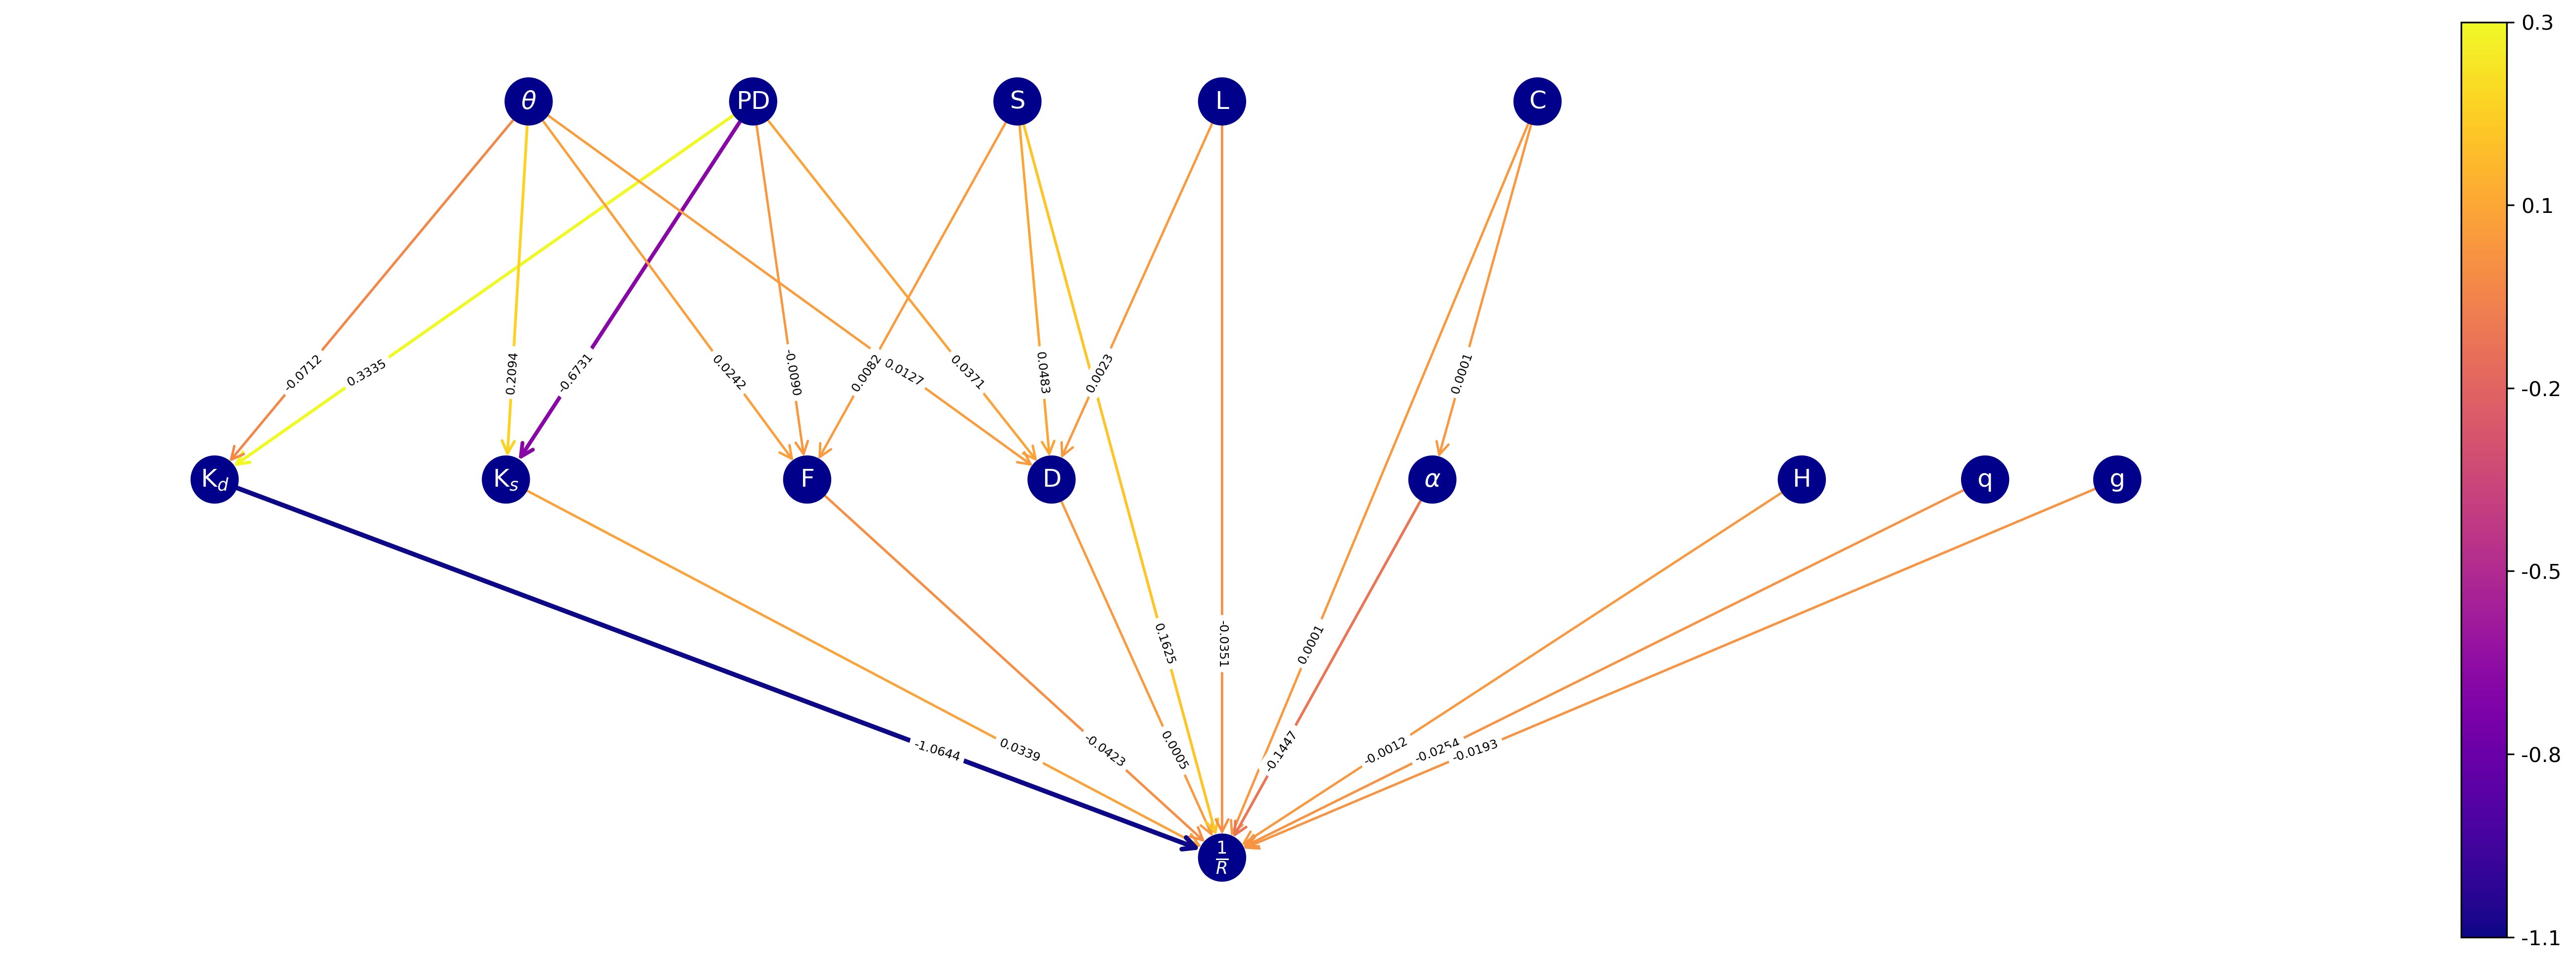

In [169]:


plt.figure(figsize=(25, 8), dpi=300)

G = nx.DiGraph()


# Add edges with 'ATE' attribute
for idx, row in df.iterrows():
    G.add_edge(row['treatment'], row['outcome'], ATE=row['ate'])

# Use spring layout
#pos = nx.spiral_layout(G)

#A = nx.drawing.nx_agraph.to_agraph(G)
#A.layout(prog='neato')
pos = nx.drawing.nx_agraph.pygraphviz_layout(G, prog='dot')

# Node sizes
node_sizes = [500 for _ in range(len(G))]

# Edge colors according to 'ATE'
# Normalize edge colors to be between 0 and 1
min_ate = -1.064408
max_ate = 0.333503
edge_colors = [(G[u][v]['ATE'] - min_ate) / (max_ate - min_ate) for u,v in G.edges()]

# Create edge alphas
M = G.number_of_edges()
node_names = list(G.nodes())
label_raw = ['PD',r'K$_s$','D',r'K$_d$','F',r'$\frac{1}{R}$',r'$\theta$','S','L','C',r'$\alpha$','H','q','g']
node_labels = {node_name: letter for node_name, letter in zip(node_names, label_raw)}

edge_widths = [1.5 * (abs(attr['ATE']) - min_ate) / (max_ate - min_ate) for u, v, attr in G.edges(data=True)]
edge_labels = {(u, v): f"{attr['ATE']:.4f}" for u, v, attr in G.edges(data=True)}

    
#pdot = nx.drawing.nx_pydot.to_pydot(G)


# Draw nodes
nodes = nx.draw_networkx_nodes(G,  pos, node_size=node_sizes, node_color='darkblue')

"""edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=15, edge_color='gray', width=edge_widths)"""
cmap = plt.cm.plasma
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=15, edge_color=edge_colors, edge_cmap=cmap, width=edge_widths)



nx.draw_networkx_labels(G,  pos, labels=node_labels,font_color='white')
# Remove the original edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=6, label_pos= 0.283, horizontalalignment = "center",verticalalignment='center')


pc = matplotlib.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()
# Define number of tick labels you want
num_ticks = 6

# Generate evenly spaced normalized values and corresponding 'ATE' values
norm_ticks = np.linspace(0, 1, num_ticks)
ate_ticks = norm_ticks * (max_ate - min_ate) + min_ate


cbar = plt.colorbar(pc, ax=ax)
cbar.set_ticks(norm_ticks)
cbar.set_ticklabels([f"{tick:.1f}" for tick in ate_ticks])
plt.savefig("DAG_weight.png",bbox_inches='tight',dpi=300)

plt.show()

In [11]:
def load_cate_data(act_func, weight_mod, lbd,layer,node,lr):
    if weight_mod == 0:
        wm = "w0"
        pref = "ovgkf97l"
    elif weight_mod == 1:
        wm = "w1"
        pref = "tqu0j7bk"
    else:
        return 'false'
    return pd.read_csv(r".\{0}\{1}_causal_effect_layer_{2}node_{3}_{4}_LR_{5}weightmod_{6}lbd_{7}.csv".format(wm,pref,layer,node,act_func,lr,weight_mod,lbd),index_col=0)

# Function to add activation function names
def add_activation_name(ax, name):
    ax.set_title(name, fontsize=11)

# Function to add lambda values
def add_lambda_value(ax, value,padding = 0.3):
    ax.annotate(
        f"$\lambda = {value}$",
        xy=(-padding, 0.5),
        xycoords="axes fraction",
        fontsize=14,
        fontweight="bold",
        rotation=90,
        ha="right",
        va="center",
    )


In [9]:

boundaries = np.array([-3, -1,-0.7,-0.5,-0.3, -0.1, -0.01, -0.001,0, 0.001, 0.01,0.1,0.3,0.5,0.7, 1, 3])
colors = [sns.color_palette("Spectral", as_cmap=True)(x) for x in np.linspace(0, 1, len(boundaries))]
#colors = [cmocean.cm.haline(x) for x in np.linspace(0, 1, len(boundaries))]
#colors = [sns.color_palette("viridis", as_cmap=True)(x) for x in np.linspace(0, 1, len(boundaries))]
segmented_cmap = ListedColormap(colors)

norm = BoundaryNorm(boundaries, len(colors))





C:\Miniconda3\envs\causal\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


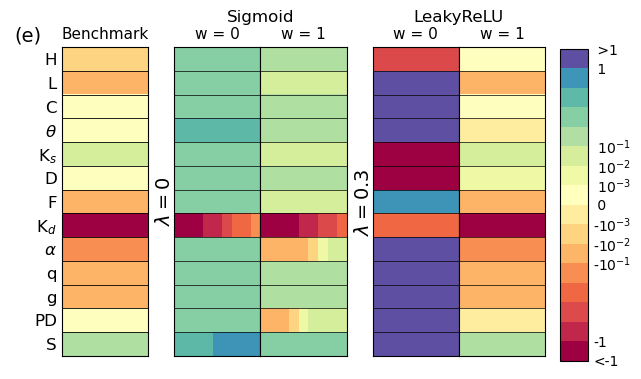

In [18]:
fig = plt.figure(figsize=(5.6, 3.8),tight_layout=True)

gs = fig.add_gridspec(1,7,width_ratios=[10,3,10,10,3,10,10],wspace=0)

params_1 = [(0,0),(1,0)]
params_2 = [(0,0.3),(1,0.3)]
act_func_dict = {1:'LeakyReLU',2:'ReLU',3:'Tanh',4:'Softplus',5:'Sigmoid'}

for i in range(1):
    for j in range(7):
        ax = fig.add_subplot(gs[i,j])

        if j == 0:
            ax.imshow(ruler, aspect="auto", cmap=segmented_cmap,norm=norm)
            
            # Major ticks
            ax.set_yticks(range(13))

            # Labels for major ticks
            ax.set_xticklabels([])
            ax.set_yticklabels(['H','L','C',r'$\theta$','K$_s$','D','F','K$_d$',r'$\alpha$','q','g','PD','S'],fontsize=12)

            # Minor ticks
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.6)

            # Remove minor ticks
            ax.tick_params(which='minor', bottom=False, left=False)
            ax.tick_params(axis='both', which='both', length=0)
            add_activation_name(ax, "Benchmark")
            

            anchored_text = AnchoredText("(e)", loc="upper left", prop=dict(size=14),borderpad = -0,bbox_to_anchor=(-0.6,1.08),bbox_transform = ax.transAxes, pad=0.2, frameon=False)
            #anchored_text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax.add_artist(anchored_text)
            
        elif j in [2,3]:
            data = load_cate_data(act_func_dict[5],*params_1[j%2],*(2,64,0.001))
            ax.imshow(data.T.iloc[:,1:], aspect="auto", cmap=segmented_cmap,norm=norm)
            ax.set_yticks(np.arange(0, 13, 1))
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.5)
            ax.tick_params(which='minor', bottom=False, left=False)
            #ax.grid( color='w', linestyle='-', linewidth=2)
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 2:
                add_lambda_value(ax, 0,padding = 0)
            add_activation_name(ax, "w = {}".format(j%2))
            if j == 2:
                ax.annotate(act_func_dict[5], xy=(1, 1.06), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size=12, ha='center', va='baseline')

        elif j in [5,6]:
            data = load_cate_data(act_func_dict[1],*params_2[(j-1)%2],*(3,64,0.05))
            ax.imshow(data.T.iloc[:,1:], aspect="auto", cmap=segmented_cmap,norm=norm)
            ax.set_yticks(np.arange(0, 13, 1))
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.5)
            ax.tick_params(which='minor', bottom=False, left=False)
            #ax.grid( color='w', linestyle='-', linewidth=2)
            ax.set_xticks([])
            ax.set_yticks([])
            add_activation_name(ax, "w = {}".format((j-1)%2))
            if j == 5:
                add_lambda_value(ax, 0.3,padding = 0)
            if j == 5:
                ax.annotate(act_func_dict[1], xy=(1, 1.06), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size=12, ha='center', va='baseline')

        else:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')

            

cbar_ax3 = fig.add_axes([1, 0.04, 0.05, 0.82])
cbar3 = fig.colorbar(ScalarMappable(norm=norm, cmap=segmented_cmap), cax=cbar_ax3,ticks=boundaries)

cbar_ax3.set_yticklabels(['<-1', '-1','','','','-$10^{-1}$','-$10^{-2}$', '-$10^{-3}$', ' 0',' $10^{-3}$',' $10^{-2}$',' $10^{-1}$','','','', ' 1',' >1'])
cbar_ax3.tick_params(axis='both', which='both', length=0)


plt.show()
fig.savefig('panel3_M30_rev_july.png',dpi=300,bbox_inches='tight')

C:\Miniconda3\envs\causal\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


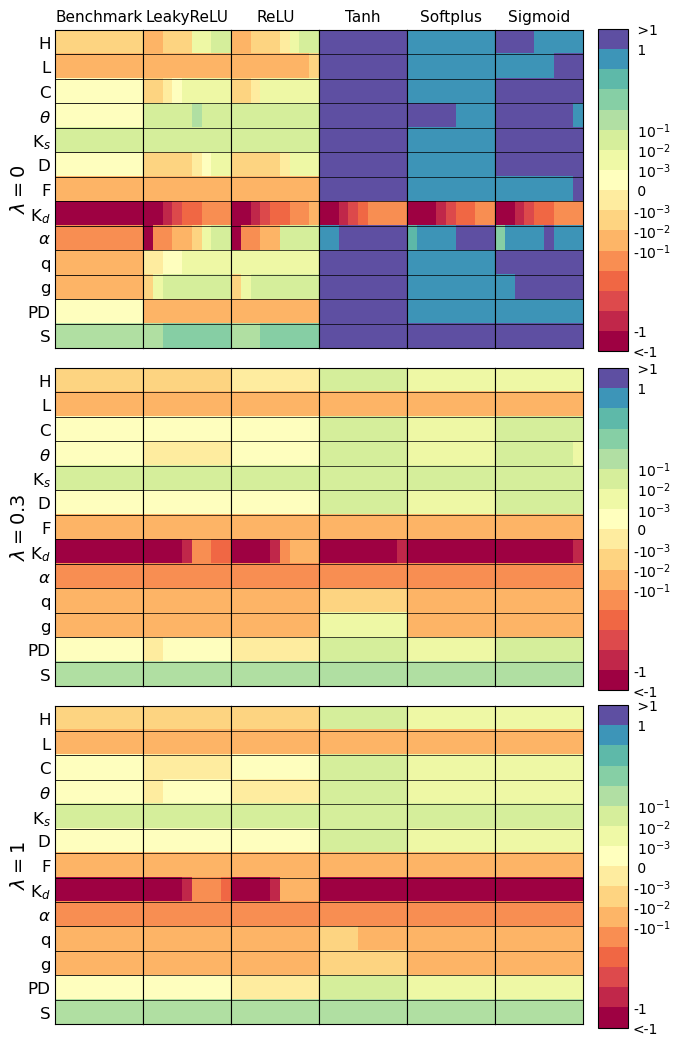

In [19]:


ruler = np.array([-0.001219236, -0.035074218, 0, 0, 0.033900008, 0.000465403, -0.042283258, -1.064407829, -0.144739628, -0.025415903, -0.019302039, 0, 0.162546474]).reshape(-1, 1)

# Plot:
fig = plt.figure(figsize=(6, 10.5),tight_layout=True)


gs = fig.add_gridspec(3,6,width_ratios=[10,10,10,10,10,10],wspace=0)

params = [(1,0),(1,0.3),(1,1)]
# Define your parameters
other_params = [
    [1, 2, 3],
    [16,32,64],
    [0.001,0.005,0.01,0.05]  # your additional parameters
]
param_combinations = list(product(*other_params))
axes = []
act_func_dict = {1:'LeakyReLU',2:'ReLU',3:'Tanh',4:'Softplus',5:'Sigmoid'}

for i in range(3):
    for j in range(6):
        ax = fig.add_subplot(gs[i,j])

        if j == 0:
            ax.imshow(ruler, aspect="auto", cmap=segmented_cmap,norm=norm)
            
            # Major ticks
            ax.set_yticks(range(13))

            # Labels for major ticks
            ax.set_xticklabels([])
            ax.set_yticklabels(['H','L','C',r'$\theta$','K$_s$','D','F','K$_d$',r'$\alpha$','q','g','PD','S'],fontsize=12)

            # Minor ticks
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.6)

            # Remove minor ticks
            ax.tick_params(which='minor', bottom=False, left=False)
            ax.tick_params(axis='both', which='both', length=0)
            
            add_lambda_value(ax, params[i][1])
            
            #if i not in (1,2):
                #anchored_text = AnchoredText("(d)", loc="upper left", prop=dict(size=14),borderpad = -0,bbox_to_anchor=(-0.7,1.07),bbox_transform = ax.transAxes, pad=0.2, frameon=False)
                #anchored_text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
                #ax.add_artist(anchored_text)
        else:
            # Create a list to store your dataframes
            dataframes = []

            # Load data for each parameter combination
            for para in param_combinations:
                dataframes.append(load_cate_data(act_func_dict[j],*params[i],*para))
            data = pd.concat(dataframes).groupby(level=0).mean()
            # Concatenate and average data
            
            #data = load_cate_data(act_func_dict[j],*params[i],*(1,32,0.01))
            ax.imshow(data.T.iloc[:,1:], aspect="auto", cmap=segmented_cmap,norm=norm)
            ax.set_yticks(np.arange(0, 13, 1))
            ax.set_yticks(np.arange(-.5, 13, 1), minor=True)
            ax.grid(axis = 'y',which='minor', color='black', linestyle='-', linewidth=0.5)
            ax.tick_params(which='minor', bottom=False, left=False)
            #ax.grid( color='w', linestyle='-', linewidth=2)
            ax.set_xticks([])
            ax.set_yticks([])
        
        if i == 0 and j > 0:
            add_activation_name(ax, act_func_dict[j])
        elif i== 0 and j == 0:
            add_activation_name(ax, "Benchmark")

cbar_ax1 = fig.add_axes([1, 0.66, 0.05, 0.307])
cbar_ax2 = fig.add_axes([1, 0.337, 0.05, 0.307])
cbar_ax3 = fig.add_axes([1, 0.016, 0.05, 0.307])

cbar1 = fig.colorbar(ScalarMappable(norm=norm, cmap=segmented_cmap), cax=cbar_ax1,ticks=boundaries)
cbar2 = fig.colorbar(ScalarMappable(norm=norm, cmap=segmented_cmap), cax=cbar_ax2,ticks=boundaries)
cbar3 = fig.colorbar(ScalarMappable(norm=norm, cmap=segmented_cmap), cax=cbar_ax3,ticks=boundaries)

for ax in [cbar_ax1,cbar_ax2,cbar_ax3]:
    ax.set_yticklabels(['<-1', '-1','','','','-$10^{-1}$','-$10^{-2}$', '-$10^{-3}$', ' 0',' $10^{-3}$',' $10^{-2}$',' $10^{-1}$','','','', ' 1',' >1'])
    ax.tick_params(axis='both', which='both', length=0)
    


    
plt.show()
fig.savefig('panel2_M30_w1.png',dpi=300,bbox_inches='tight')